# **<center><font style="color:rgb(100,109,254)">Module 8: Emotion Recognition + AI Filters</font> </center>**

<center>
    <img src='https://drive.google.com/uc?export=download&id=1ekabh-KWOZhj8UPjf5AbZLzQ767z52_T' width=800> 
    <br/>
    <a href='https://www.shutterstock.com/image-photo/emotion-detected-by-artificial-intelligence-ai-1898196328'>Image Credits</a>
</center>
    

## **<font style="color:rgb(134,19,348)"> Module Outline </font>**

The module can be split into the following parts:

- *Lesson 1: Introduction to Support Vector Machine Theory.*

- ***Lesson 2:* Train an Emotion Recognition SVM on FER+ Dataset.** *(This Tutorial)*

- *Lesson 3: Create your own Dataset for Emotion Recognition.*

- *Lesson 4: Create AI Filters With Emotion Recognition Based Triggers.*


**Please Note**, these Jupyter Notebooks are not for sharing; do read the Copyright message below the Code License Agreement section which is in the last cell of this notebook.
-Taha Anwar

Alright, let's get started.

### **<font style="color:rgb(134,19,348)"> Import the Libraries</font>**

First, we will import the required libraries.

In [1]:
import os
import cv2
import pickle
import itertools
import numpy as np
import pandas as pd
import mediapipe as mp
from sklearn import svm
import matplotlib.pyplot as plt
from previous_lesson import detectFacialLandmarks
from importlib.metadata import version
print(f"Mediapipe version: {version('mediapipe')}, it should be 0.8.9.1")

Mediapipe version: 0.8.10.1, it should be 0.8.9.1


## **<font style="color:rgb(134,19,348)">Initialize the Face Landmarks Detection Model</font>**

After that, we will initialize the **`mp.solutions.face_mesh`** class and set up the **`mp.solutions.face_mesh.FaceMesh()`** function (for images and videos as well) with appropriate arguments as we have been doing in the previous lessons.

In [2]:
# Initialize the mediapipe face mesh class.
mp_face_mesh = mp.solutions.face_mesh

# Setup the face landmarks function for images.
face_mesh_images = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1,
                                         refine_landmarks=True, min_detection_confidence=0.3)

# Setup the face landmarks function for videos.
face_mesh_videos = mp_face_mesh.FaceMesh(static_image_mode=False, max_num_faces=1, refine_landmarks=True,
                                         min_detection_confidence=0.8, min_tracking_confidence=0.6)

## **<font style="color:rgb(134,19,348)">Facial Emotion Recognition (FER) Dataset</font>**

The [Facial Expression Recognition dataset (FER)](https://www.kaggle.com/datasets/msambare/fer2013) is a dataset provided by Kaggle, introduced at the [In-ternational Conference on Machine Learning (ICML)](https://icml.cc/2013/) in 2013. The data consists of around 30k 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centered and occupies about the same amount of space in each image. The images are classified into seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral).

Whereas the FER+ dataset is an extension of the original FER dataset, where the images have been re-labeled into one of 8 emotion types: neutral, happiness, surprise, sadness, anger, disgust, fear, and contempt. In FER+, each image has been labeled by 10 crowd-sourced taggers, which provide better quality ground truth for still image emotion than the original FER labels. We will be working with the FER+ dataset in this tutorial, below are some examples of the FER vs FER+ labels taken from a [paper](https://arxiv.org/abs/1608.01041) (FER top, FER+ bottom): 

<center><img src='https://drive.google.com/uc?export=download&id=1jrvC9GqVPxzL2-QuJJWM3EoXySw0D7Tc'></center>

### **<font style="color:rgb(134,19,348)">Clone the Dataset Repository</font>**

Now we will clone the [repository](https://github.com/microsoft/FERPlus.git) which contains the FER+ dataset in the form of a .csv file (with pixel values of the images stored in columns and rows) and also contains the script to generate the images from the .csv file. 

In [3]:
# Clone the https://github.com/microsoft/FERPlus github repository.
!git clone https://github.com/microsoft/FERPlus.git

fatal: destination path 'FERPlus' already exists and is not an empty directory.


### **<font style="color:rgb(134,19,348)">Generate the Dataset</font>**

Now, as we have cloned the repository, we will utilize a script `FERPlus/src/generate_training_data.py` (inside the cloned repository) to generate the dataset images from the .csv file and store them on the disk.

In [4]:
# Change current working directory to the 'FERPlus/src'.
os.chdir(r"FERPlus/src")

# Generate the dataset images from the pixel values stored in the .csv file.
!python generate_training_data.py -d ../data -fer ../fer2013.csv -ferplus ../fer2013new.csv 

# Go back to the original working directory.
os.chdir(r"../../")

Start generating ferplus images.
Done...


### **<font style="color:rgb(134,19,348)">Get Training and Test Set Info</font>**

Now you should have all the images stored inside the `FERPlus/data` directory, we can now get the total number of images present inside the training and test set of each class to get an idea about the data distribution.

In [5]:
# Read a fer2013new csv file into DataFrame.
df = pd.read_csv(r'FERPlus/fer2013new.csv')

# Specify the path of the dataset.
DATASET_DIR  = 'FERPlus/data'

# Specify the classes with which we are gonna be working with.
expressions = ['happiness', 'anger', 'surprise']

# Initialize a dictionary to store the training and test images names. 
images_names = {}

# Specify the minimum voting score.
# This should be greater than 5, as the total voters are 10.
MIN_VOTING = 6

# Iterate over the specified classes.
for expression in expressions:
    
    # Initialize two lists inside the dictionary, to store the training and test images names 
    # of the expression we are iterating upon.
    images_names[expression] = {'train':[], 'test':[]}
    
    # Iterate over the DataFrame rows.
    for index, row in df.iterrows():
        
        # Check if the voting score of the image is > minimum voting score.
        if row[expression] >= MIN_VOTING:
            
            # Check if the image belongs to the training set. 
            if row['Usage'] == 'Training':
            
                # Append the image name into the list.
                images_names[expression]['train'].append(row['Image name'])
            
            # Check if the image belongs to the test set. 
            elif row['Usage'] == 'PrivateTest':
                
                # Append the image name into the list.
                images_names[expression]['test'].append(row['Image name'])
    
    print('----------------------------------------------------------')
    
    # Display the number of training and test images of the class we are iterating upon.
    print(f"Number of training images in class {expression}: {len(images_names[expression]['train'])}")
    print(f"Number of test images in class {expression}: {len(images_names[expression]['test'])}")
    
    print('----------------------------------------------------------')

----------------------------------------------------------
Number of training images in class happiness: 7083
Number of test images in class happiness: 872
----------------------------------------------------------
----------------------------------------------------------
Number of training images in class anger: 1643
Number of test images in class anger: 219
----------------------------------------------------------
----------------------------------------------------------
Number of training images in class surprise: 2742
Number of test images in class surprise: 341
----------------------------------------------------------


In [6]:
df.head()

,Usage,Image name,neutral,happiness,surprise,sadness,anger,disgust,fear,contempt,unknown,NF
0,Training,fer0000000.png,4,0,0,1,3,2,0,0,0,0
1,Training,fer0000001.png,6,0,1,1,0,0,0,0,2,0
2,Training,fer0000002.png,5,0,0,3,1,0,0,0,1,0
3,Training,fer0000003.png,4,0,0,4,1,0,0,0,1,0
4,Training,fer0000004.png,9,0,0,1,0,0,0,0,0,0


As you can clearly see the class imbalance (unequal distribution of classes) in the training dataset, this can severely affect our model during training in a bad manner, and there are several techniques out there to tackle this problem but for the sake of simplicity, we are just gonna find the minimum number of samples present of a class (i.e., `anger` in our use case) and skip all the extra images in the other two classes (i.e., `happiness` and `surprise`) to make the number of images equal in all three classes.

In [7]:
# Initialize a variable to store the minimum number of training images in a class.
min_train_samples = len(images_names[expressions[0]]['train'])

# Iterate over the training images names dictionary items.
for expression, images in images_names.items():
    
    # Check if the length of images names i.e., the total number of images of the 
    # class we are iterating upon is < minimum number of images.
    if len(images['train']) < min_train_samples:
        
        # Update the minimum number of images.
        min_train_samples = len(images['train'])

# Display the minimum number of images.
print(f'The minimum number of training sample images in a class are: {min_train_samples}')

The minimum number of training sample images in a class are: 1643


## **<font style="color:rgb(134,19,348)">Create a Function to Extract Facial Landmarks</font>**


Now we will create a function **`extractKeypoints()`**, that will extract the facial landmarks detected by the **`detectFacialLandmarks()`** (created in a previous module). Remember that, we had converted the Face landmarks x and y coordinates into their original scale in the function **`detectFacialLandmarks()`**, so now we will have to normalize the coordinates back to the range [0-1], as this is required to make the model robust while working with images of different resolutions.

In [8]:
def extractKeypoints(image, face_mesh):
    '''
    This function will extract the Landmarks (after normalization) of a Face in an image.
    Args:
        image:     The input image of the person whose facial landmarks needs to be extracted.
        face_mesh: The Mediapipe's face landmarks detection function required to perform the landmarks detection.
    Returns:
        extracted_landmarks: An array containing the extracted normalized facial landmarks (x and y coordinates).
    '''
    
    # Retrieve the height and width of the image.
    image_height, image_width, _ = image.shape
    
    # Perform the Face landmarks detection on the image.
    image, face_landmarks = detectFacialLandmarks(image, face_mesh, draw=False, display=False)
    
    # Initialize a list to store the extracted landmarks.
    extracted_landmarks = []
    
    # Check if facial landmarks are found. 
    if len(face_landmarks) > 0:
            
        # Iterate over the indexes of the face landmarks. 
        for index in set(list(itertools.chain(*mp_face_mesh.FACEMESH_TESSELATION))):
            
            # Normalize the landmarks and append them into the list.
            extracted_landmarks.append((face_landmarks[index][0]/image_width, face_landmarks[index][1]/image_height))
        
    # Convert the list into an array.
    extracted_landmarks = np.array(extracted_landmarks)
    
    # Return the extracted normalized facial landmarks.
    return extracted_landmarks

Now we will utilize the function **`extractKeypoints()`**, created above to extract landmarks from the training and test set.

In [22]:
# Specify the path of the training set. 
TRAIN_DATA_DIR = os.path.join(DATASET_DIR, 'FER2013Train')

# Specify the path of the test set. 
TEST_DATA_DIR = os.path.join(DATASET_DIR, 'FER2013Test')

# Initialize a few lists to store the training and test landmarks and labels.
train_landmarks, train_labels, test_landmarks, test_labels = [], [], [], []

# Initialize a dictionary to store the training images count. 
train_images_count = {}

# Create named window for resizing purposes.
# cv2.namedWindow('Landmarks Extraction', cv2.WINDOW_NORMAL)

# Iterate over the classes.
for class_index, expression in enumerate(expressions):
    
    # Get the training images names of the class we are iterating upon.
    images_dict = images_names[expression]
    
    # Initialize an element (key-value pair) to store the training images count for the expression, we are iterating upon. 
    train_images_count[expression] = 0
    
    # Initialize a variable to store the test images count for the expression, we are iterating upon. 
    test_images_count = 0
    
    # Iterate over the train-test split.
    for dataset_split, images_names_list in images_dict.items():
        
        # Iterate over the extracted images names.
        for image_name in images_names_list:
            
            # Check if the the image belongs to the train split.
            if dataset_split == 'train':
                
                # Get the path of the image i.e., inside the training set directory.
                image_path = os.path.join(TRAIN_DATA_DIR, image_name)
                
            # Otherwise.
            else:
                
                # Get the path of the image i.e., inside the test set directory.
                image_path = os.path.join(TEST_DATA_DIR, image_name)
        
            # Read the image.
            image = cv2.imread(image_path)

            # Extract the required face keypoints of the person in the image.
            extracted_keypoints = extractKeypoints(image, face_mesh_images)
            
            # Flatten the extracted keypoints array.
            extracted_keypoints = extracted_keypoints.flatten()

            # Display the image
            # cv2.imshow("Landmarks Extraction", image)

            # Check if the keypoints were extracted successfully.
            if len(extracted_keypoints) > 0:

                # Wait for 1ms. 
                # cv2.waitKey(1)
                
                # Check if the image belongs to the train split.
                if dataset_split == 'train':

                    # Append the extracted keypoints into the train landmarks list.
                    train_landmarks.append(extracted_keypoints)

                    # Append the label of the image into the train labels list.
                    train_labels.append(expression)
                    
                    # Add one into the training images count.
                    train_images_count[expression] += 1

                    # Check if the number of training landmarks of the class are equal to the minimum number.
                    if len(train_landmarks)//(class_index+1) == min_train_samples:

                        # break the loop.
                        break
                
                # Otherwise.
                else:
                    
                    # Append the extracted keypoints into the test landmarks list.
                    test_landmarks.append(extracted_keypoints)

                    # Append the label of the image into the test labels list.
                    test_labels.append(expression)
                    
                    # Add one into the test images count.
                    test_images_count+=1
                    
            # Otherwise.
            # else:
            
                # Wait until a key is press.
                # cv2.waitKey(0)
    
    # Display the success message.
    print(f'Landmarks Extraction for {expression.upper()} Completed,')
    print(f'With Total Training Images: {train_images_count[expression]} and Total Test images: {test_images_count}.', end='\n\n')

# Close the windows.
# cv2.destroyAllWindows()

Landmarks Extraction for HAPPINESS Completed,
With Total Training Images: 1472 and Total Test images: 866.

Landmarks Extraction for ANGER Completed,
With Total Training Images: 1472 and Total Test images: 199.

Landmarks Extraction for SURPRISE Completed,
With Total Training Images: 1472 and Total Test images: 336.



As you can see, we still don't have an equal number of training images in all classes, as our landmark detection model failed to detect landmarks in a few training images. So we will have to further refine the Landmarks Dataset.

In [10]:
# Initialize a few lists to store the refined training landmarks and labels.
refined_train_landmarks, refined_train_labels = [], []

# Get the minimum number of training images count over all the classes, for which we have extracted the landmarks.
min_train_samples = min(train_images_count.values())

# Initialize a variable to store the difference between the images count of the classes 
# and minimum number of training images over all the classes.
difference = 0

# Iterate over the images count of the classes, for which we have extracted the landmarks.
for class_index, images_count in enumerate(train_images_count.values()):
    
    # Get the training landmarks (equal to the minimum number of training images count) of the class we are iterating upon.
    class_landmarks = train_landmarks[(class_index * min_train_samples) + difference:
                                      ((class_index * min_train_samples) + difference) + min_train_samples]
    
    # Get the training labels (equal to the minimum number of training images count) of the class we are iterating upon.
    class_labels = train_labels[(class_index*min_train_samples) + difference:
                                ((class_index*min_train_samples) + difference)+min_train_samples]
    
    # Extend the extracted landmarks into the list.
    refined_train_landmarks.extend(class_landmarks)
    
    # Extend the extracted labels into the list.
    refined_train_labels.extend(class_labels)
    
    # Calculate the difference between the images count of the class (we are iterating upon) and
    # the minimum number of training images over all the classes, and add it into the previous difference.
    difference += images_count - min_train_samples
    
    # Raise an AssertionError exception, if something went wrong during the refinement process.
    # This is done to make sure that the refined train labels only contain the label of the class, we are iterating upon.
    assert set(class_labels) == {expressions[class_index]}, f'{set(class_labels)}, this should only contain {expressions[class_index]}.'

# Display the success message.
print("Successfully Refined the Dataset.")

Successfully Refined the Dataset.


In [11]:
min(train_images_count.values())

1472

**Note:** What we've just done, is made sure that we have equal training images and labels for all the classes. This makes sure all classes have equal representation. This will help us avoid overfitting regardless of the kind of model we use.

## **<font style="color:rgb(134,19,348)">Train the Model</font>**

Now that we have the keypoints dataset ready, we can start training our SVM on it.

In [12]:
# Initializing the SVM Model.
model = svm.SVC(kernel='poly', degree=3, C = 1.0, probability=True)

# Start training the model on the training dataset.
model.fit(refined_train_landmarks, refined_train_labels)
print("Training Completed")

Training Completed


## **<font style="color:rgb(134,19,348)">Evaluate the Model</font>**

Now, after completing the training process, we can pass the test dataset to the model to evaluate its performance.

In [13]:
# Get the mean accuracy on the given test data and labels, and display it.
score = model.score(test_landmarks, test_labels)
print('Accuracy of the Model is {:.2f}%'.format(score*100))

Accuracy of the Model is 89.44%


## **<font style="color:rgb(134,19,348)">Save the Model</font>**

The evaluation results are quite satisfying, so we can now move on to saving the model into our disk.

In [14]:
# Save the model.
pickle.dump(model, open('model/face_expression.sav', 'wb'))

## **<font style="color:rgb(134,19,348)">Create a Function to Predict Emotions</font>**

Now we will create a function **`predictEmotion()`** that will utilize the model we have trained to predict the emotion (face expression) of the person inside an image/frame.

In [16]:
def predictEmotion(image, face_landmarks, loaded_model, threshold=0.7, draw=True, display=True):
    '''
    This function will predict the face expression of the person in the input image.
    Args:
        image:          The input image of the person whose face expression are to be predicted.
        face_landmarks: The extracted face keypoints of the person inside the input image.
        loaded_model:   The svm model (that we had trained and saved), loaded from the disk.
        threshold:      A threshold value between 0 and 1 which will be used to filter out false positives.
                        The probability of the prediction of the model has to be greater than this threshold 
                        value in order to consider the output valid.
        draw:           A boolean value that is if set to true the function draws a bounding box around the 
                        face and writes the predicted expression near the face.
        display:        A boolean value that is if set to true the function displays the output image and
                        returns nothing.
    Returns:
        expresson: The predicted face expression of the person inside the input image.
    '''
    
    def drawBoundingBox(image, face_landmarks, expression, padd_amount=10):
        '''
        This function draws a bounding box around the face and writes the predicted expression near the face.
        Args:
            image:          The image of the face on which the bounding box around the face needs to be drawn 
                            and the predicted expression needs to be written.
            face_landmarks: The extracted keypoints of the face in the input image around which the 
                            bounding box needs to be drawn.
            expression:     The predicted expression of the face around which the bounding box needs to be drawn.
            padd_amount:    The value that specifies the space inside the bounding box between the face and 
                            the box's borders.    
        Returns:
            output_image: A copy of the input image of the face with the bounding boxes drawn and 
                          the predicted expression written.
        '''
        
        # Create a copy of the input image to draw bounding boxes on and write predicted expression.
        output_image = image.copy()
        
        # Retrieve the height and width of the image.
        image_height, image_width, _ = image.shape
        
        # Get all the x-coordinate values from the found landmarks of the face.
        x_coordinates = np.array(face_landmarks)[:, 0] * image_width
        
        # Get all the y-coordinate values from the found landmarks of the face.
        y_coordinates = np.array(face_landmarks)[:, 1] * image_height
        
        # Get the bounding box coordinates for the face with the specified padding.
        x1  = int(np.min(x_coordinates) - padd_amount)
        y1  = int(np.min(y_coordinates) - padd_amount)
        x2  = int(np.max(x_coordinates) + padd_amount)
        y2  = int(np.max(y_coordinates) + padd_amount)
        
        # Check if the expression is 'Unknown'.
        if expression == 'Unknown':
            
            # Set the color to red.
            color = (0,0,255)
            
        # Otherwise.
        else:
            
            # Set the color to green.
            color = (0,255,0)
        
        # Draw bounding box around the face on the input image using the retrieved coordinates.
        cv2.rectangle(output_image, pt1=(x1, y1), pt2=(x2, y2), color=color, thickness=image_width//200)
        
        # Draw a filled rectangle near the bounding box of the face.
        # We are doing it to change the background of the predicted expression to make it easily visible.
        cv2.rectangle(output_image, pt1=(x1, y1-image_width//19), pt2=(x1+(len(expression)*(image_width//35)), y1),
                      color=color, thickness=-1)

        # Write the predicted expression of the face near the bounding box and on the filled rectangle. 
        cv2.putText(output_image, text=expression.upper(), org=(x1+image_width//90, y1-25), 
                    fontFace=cv2.FONT_HERSHEY_COMPLEX, fontScale=image_width//700,
                    color=(255,255,255), thickness=image_width//200)
        
        # Return the resultant image.
        return output_image
        
    # Initialize a variable to store the predicted face expression.
    expression = 'Unknown'
    
    # Get the probabilites of the classes (face expressions) on which the model is trained on.
    predicted_probabilities = loaded_model.predict_proba(face_landmarks.flatten().reshape(1,-1))[0]

    # Check if the highest predicted probability of a class is > the threshold value.
    if predicted_probabilities[np.argmax(predicted_probabilities)] > threshold:

        # Get the class (face expression) name which has the highest predicted probability.
        expression = loaded_model.classes_[np.argmax(predicted_probabilities)]
    
    # Check if the bounding box is specified to be drawn.
    if draw:
        
        # Draw a bounding box around the face and write the predicted expression on the image.
        image = drawBoundingBox(image, face_landmarks, expression)    
        
    # Check if the image is specified to be displayed.
    if display:
        
        # Display the resultant image.
        plt.figure(figsize=[10,10])
        plt.imshow(image[:,:,::-1]);plt.title("Output Image");plt.axis('off');
        
    # Otherwise.
    else:
    
        # Return the resultant image and the predicted face expression.
        return image, expression

Now we will utilize the function **`predictEmotion()`** created above, to predict emotions on a few sample images.

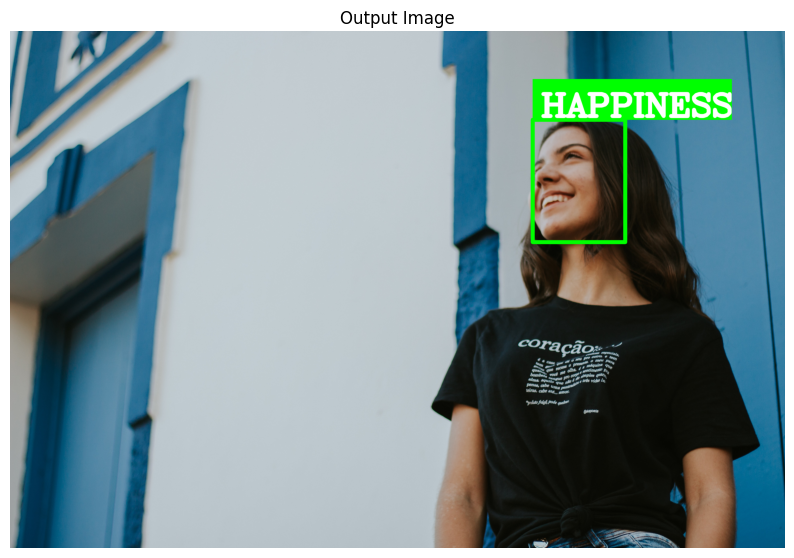

In [17]:
# Read a sample image and predict the face expression of the person inside the image.
image = cv2.imread('media/sample1.jpg')
face_landmarks = extractKeypoints(image, face_mesh_images)
if len(face_landmarks)>0:
    loaded_model = pickle.load(open('model/face_expression.sav', 'rb'))
    current_expression = predictEmotion(image, face_landmarks, loaded_model)

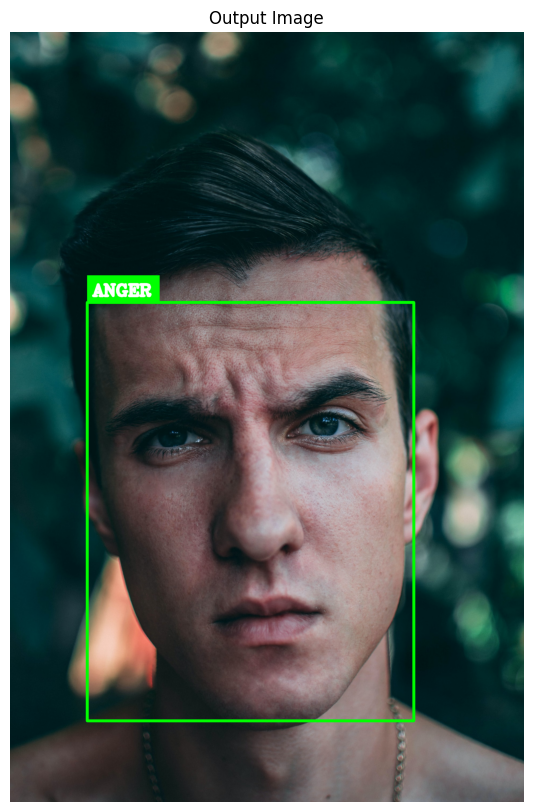

In [18]:
# Read another sample image and predict the face expression of the person inside the image.
image = cv2.imread('media/sample2.jpg')
face_landmarks = extractKeypoints(image, face_mesh_images)
if len(face_landmarks)>0:
    loaded_model = pickle.load(open('model/face_expression.sav', 'rb'))
    current_expression = predictEmotion(image, face_landmarks, loaded_model)

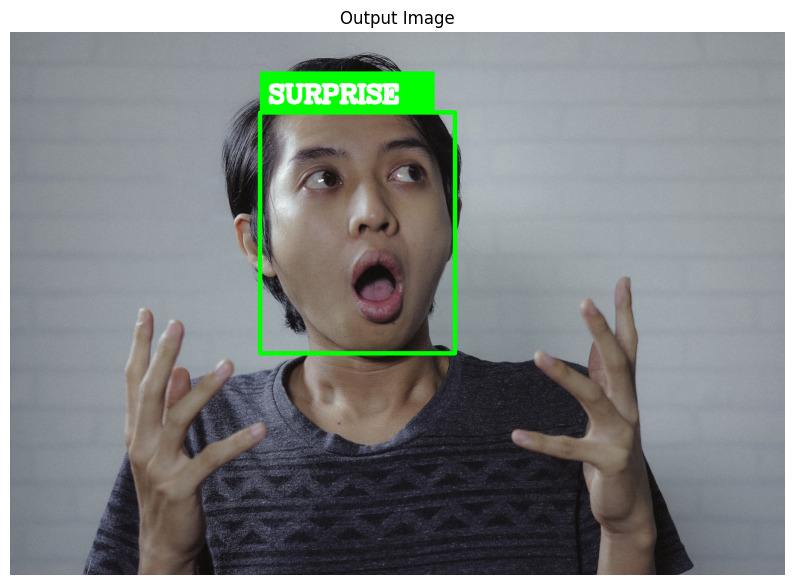

In [19]:
# Read another sample image and predict the face expression of the person inside the image.
image = cv2.imread('media/sample3.jpg')
face_landmarks = extractKeypoints(image, face_mesh_images)
if len(face_landmarks)>0:
    loaded_model = pickle.load(open('model/face_expression.sav', 'rb'))
    current_expression = predictEmotion(image, face_landmarks, loaded_model)

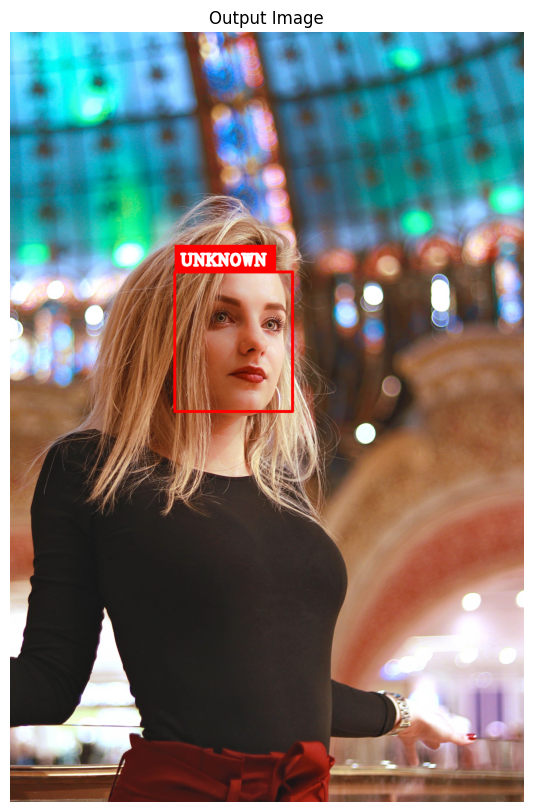

In [20]:
# Read another sample image and predict the face expression of the person inside the image.
image = cv2.imread('media/sample4.jpg')
face_landmarks = extractKeypoints(image, face_mesh_images)
if len(face_landmarks)>0:
    loaded_model = pickle.load(open('model/face_expression.sav', 'rb'))
    current_expression = predictEmotion(image, face_landmarks, loaded_model)



## **<font style="color:rgb(134,19,348)">Predict Emotions On Real-Time Web-cam Feed</font>**

Working perfectly fine on images, but how will the model we trained above, will perform on a real-time webcam feed? Well, let’s check it. 

In [21]:
# Initialize the VideoCapture object to read from the webcam.
camera_video = cv2.VideoCapture(0)
camera_video.set(3,1280)
camera_video.set(4,960)

# Create named window for resizing purposes.
cv2.namedWindow('Emotion Recognition', cv2.WINDOW_NORMAL)

# load the model from disk
loaded_model = pickle.load(open('model/face_expression.sav', 'rb'))

# Iterate until the webcam is accessed successfully.
while camera_video.isOpened():
   
    # Read a frame.
    ok, frame = camera_video.read()
    
    # Check if frame is not read properly then 
    # continue to the next iteration to read the next frame.
    if not ok:
        continue
        
    # Flip the frame horizontally for natural (selfie-view) visualization.
    frame = cv2.flip(frame, 1)
    
    # Get the height and width of the frame of the webcam video.
    frame_height, frame_width, _ = frame.shape
    
    # Extract the required face keypoints of the person in the frame.
    face_landmarks = extractKeypoints(frame, face_mesh_videos)
    
    # Check if the keypoints were extracted successfully.
    if len(face_landmarks) > 0:
        
        # Predict the face expression of the person inside the frame.
        current_expression = predictEmotion(frame, face_landmarks, loaded_model, threshold=0.4, display=False)
    
    # Display the frame.
    cv2.imshow("Emotion Recognition", frame)
    
    # Wait for 1ms. If a key is pressed, retreive the ASCII code of the key.
    k = cv2.waitKey(1) & 0xFF
    
    # Check if 'ESC' is pressed and break the loop.
    if(k == 27):
        break
         
# Release the VideoCapture Object and close the windows.
camera_video.release()
cv2.destroyAllWindows()



# Additional comments:
#       - In this program, we used the fer2013Plus to generate
#         the dataset. 
#       - After we have the dataset, we use the mediapipe face mesh
#         to get the landmarks on the face. We process the landmarks,
#         remove instances where face mesh detection failed, and 
#         finally we make sure that the number of data for each class
#         is the same.
#       - After that, we train a model. However, just like the video 
#         on lecture 2, my face wasn't recognized by the program.

Not satisfying results? Well, this can be because the way you are making the expressions is a lot different than the expressions in the images of the dataset. And this issue arises very often while solving a real-life problem through Machine Learning. The dataset on which the model is trained does not effectively cover the cases that can occur in the broader domain. The only way to tackle this problem is to collect larger and more representative samples of data from the domain and this is exactly what we are gonna do in the next lesson.

### **<font style="color:rgb(255,140,0)"> Code License Agreement </font>**
```
Copyright (c) 2022 Bleedai.com

Feel free to use this code for your own projects commercial or noncommercial, these projects can be Research-based, just for fun, for-profit, or even Education with the exception that you’re not going to use it for developing a course, book, guide, or any other educational products.

Under *NO CONDITION OR CIRCUMSTANCE* you may use this code for your own paid educational or self-promotional ventures without written consent from Taha Anwar (BleedAI.com).

```

